In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import SpectralClustering


from adjustText import adjust_text

from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('stopwords')
from gensim.models.coherencemodel import CoherenceModel

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Загружаем данные. Будем кластеризовать опоссумов и сравнивать с существующим классом Pop - популяция.

In [22]:
df = pd.read_csv('possum.csv')
df.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


Удаляем пропуски.

In [23]:
df.isnull().sum()

case        0
site        0
Pop         0
sex         0
age         2
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    1
earconch    0
eye         0
chest       0
belly       0
dtype: int64

In [24]:
df = df.dropna().reset_index(drop=True)
df.drop('case', axis=1, inplace=True)

In [25]:
df.groupby('Pop').size()

Pop
Vic      43
other    58
dtype: int64

Смотрим pairplot. Удаляем выбросы.

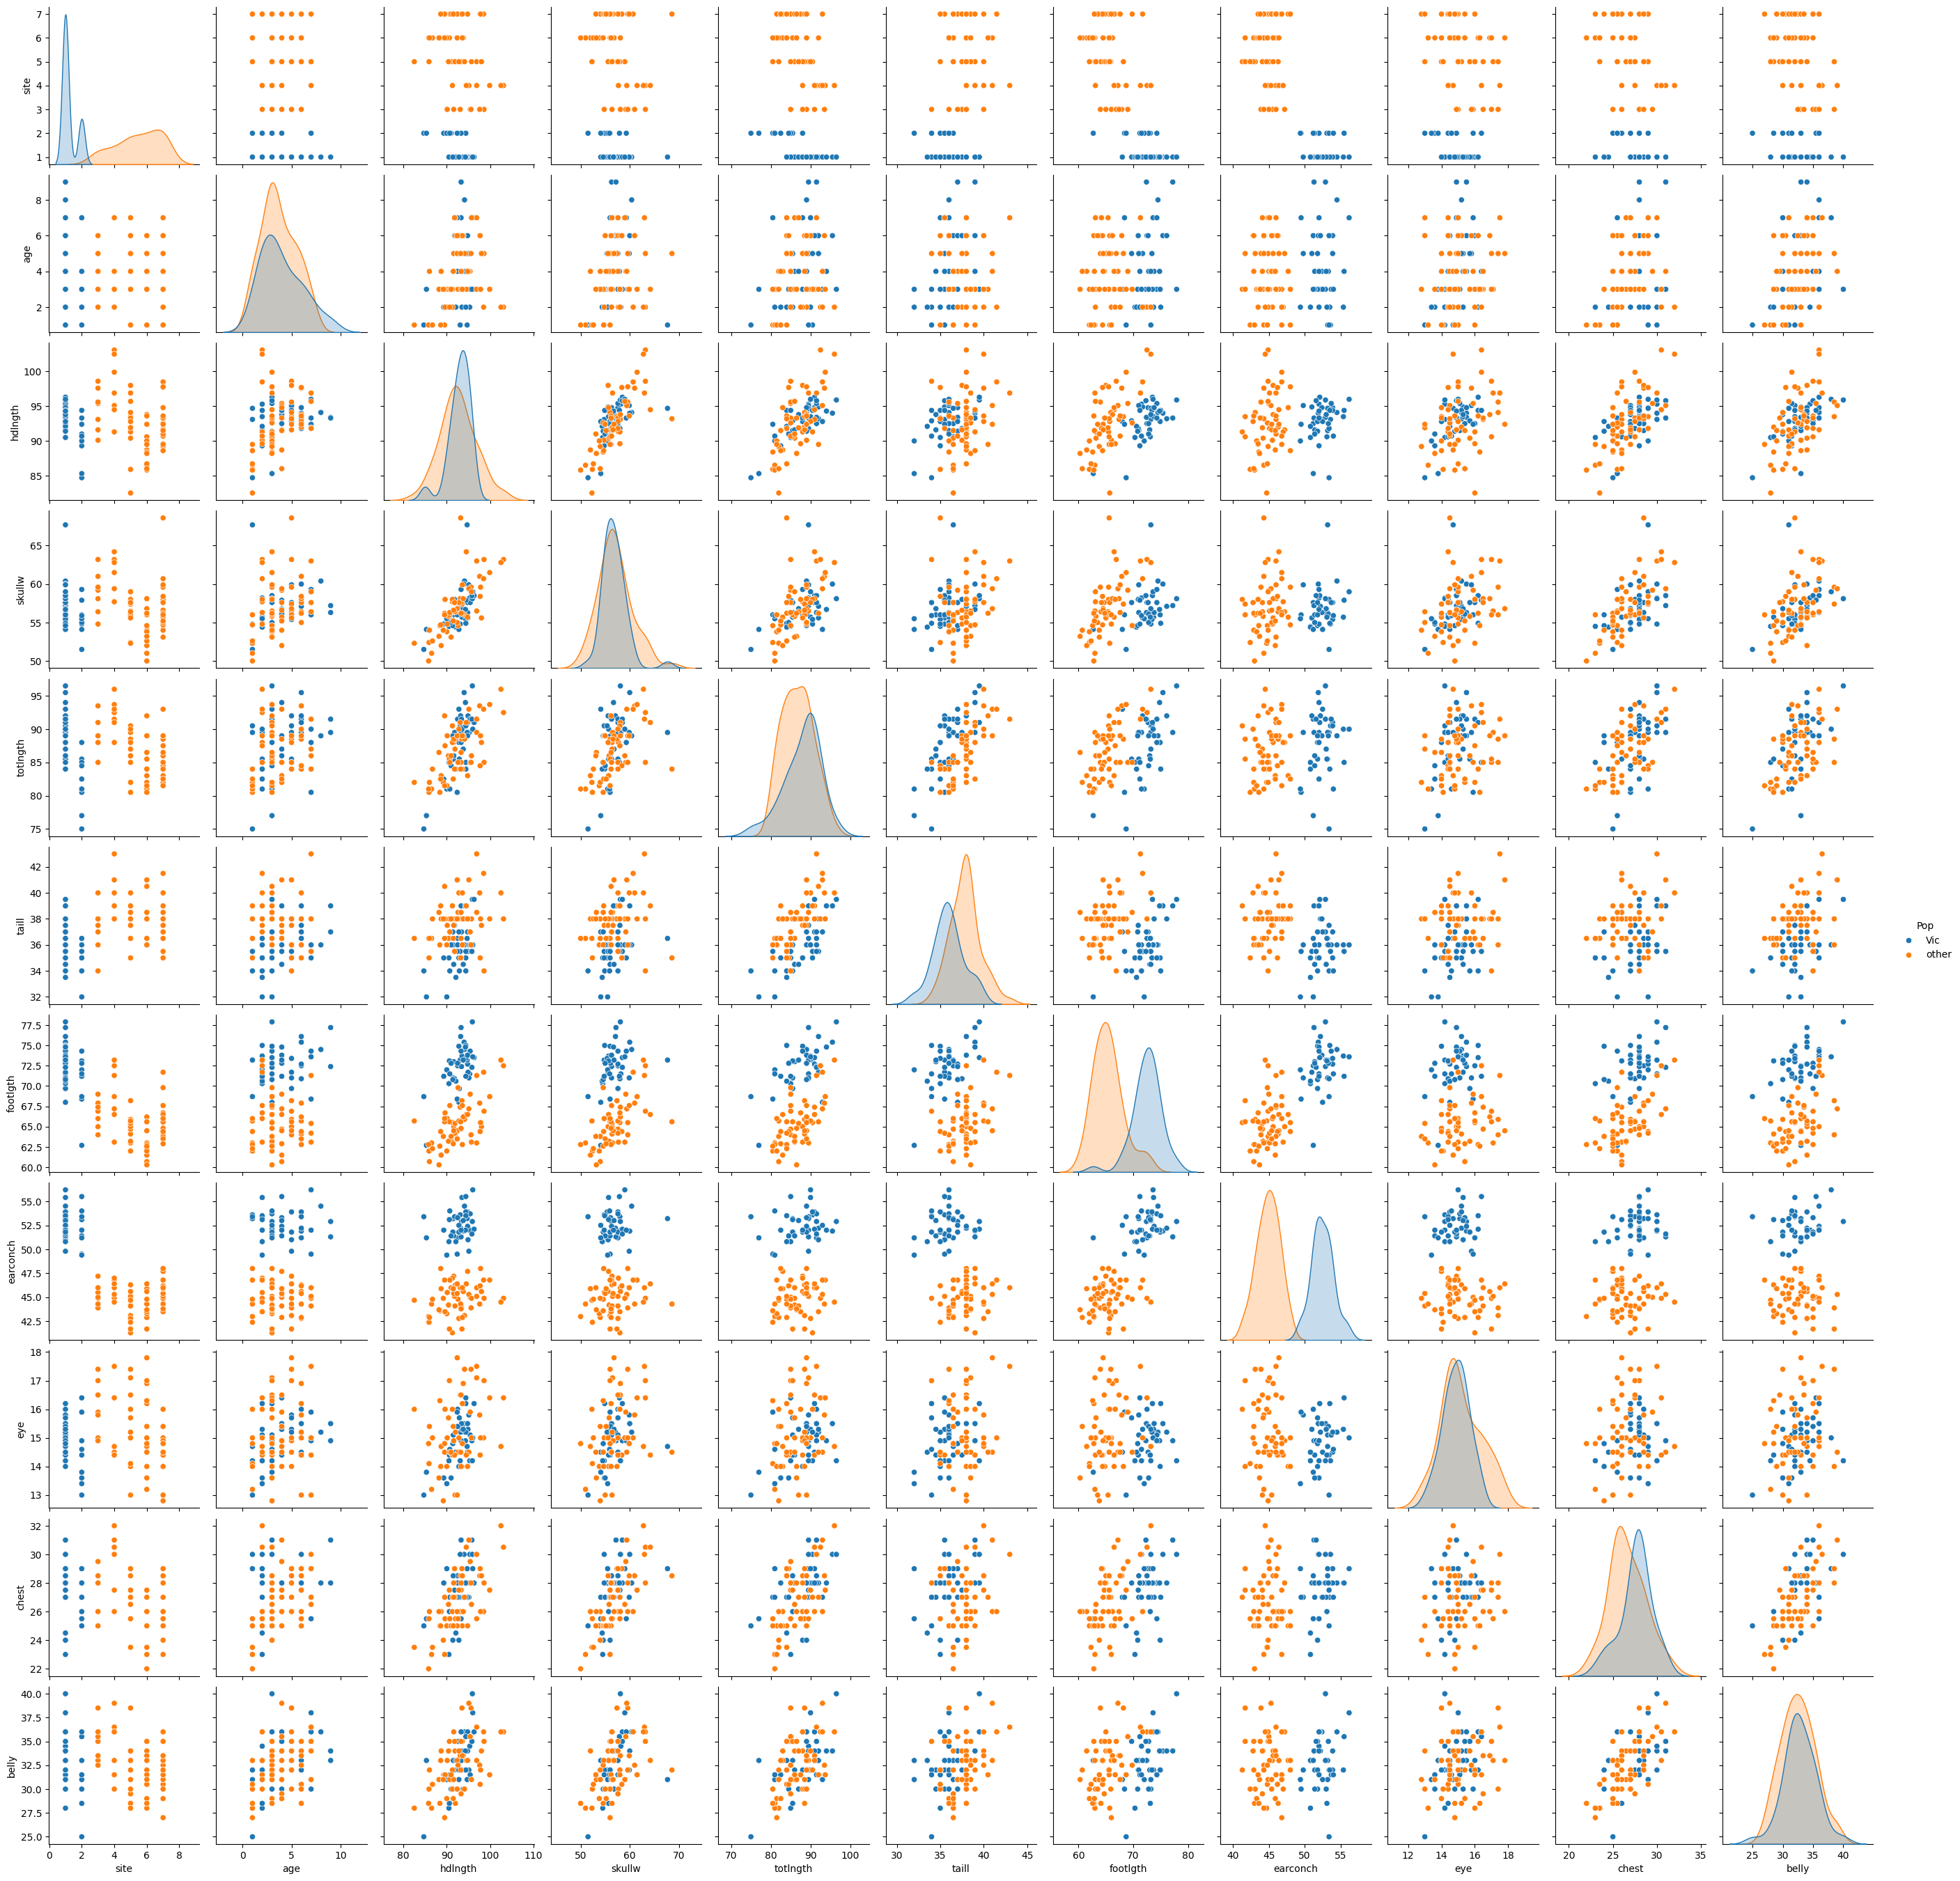

In [26]:
sns.pairplot(df, hue='Pop', palette='tab10')

In [27]:
print(df.shape)
clean_df = df[(df['skullw'] < 65)].reset_index(drop=True)
clean_df.shape

(101, 13)


(99, 13)

In [28]:
clean_df = clean_df.drop(['sex', 'site'], axis=1)

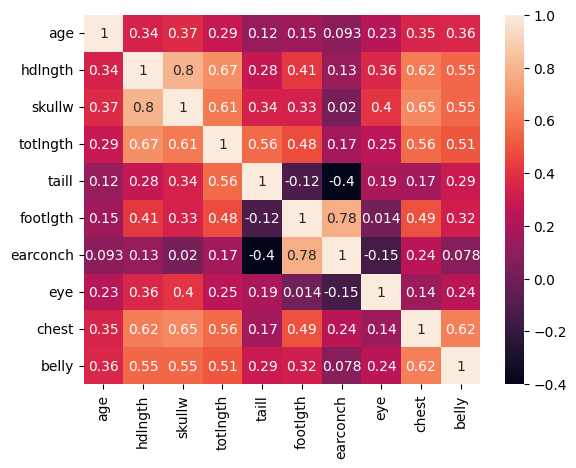

In [29]:
sns.heatmap(clean_df.iloc[:, 1:].corr(), annot=True)
plt.show()

In [30]:
scaler = StandardScaler()
scaled_df = clean_df.copy()
scaled_df.iloc[:, 1:] = scaler.fit_transform(clean_df.iloc[:, 1:])

In [31]:
scaled_df['is_Vic'] = scaled_df['Pop'].apply(lambda x: 1 if x == 'Vic' else 0)
scaled_df.drop('Pop', axis=1, inplace=True)
X = scaled_df.iloc[:, :-1]

Возьмем первые 3 главные компоненты.

[0.42932819 0.19752121 0.09682813 0.07909964 0.06613449 0.04907632
 0.03107365 0.02192693 0.01503449 0.01397695]
1.0000000000000002


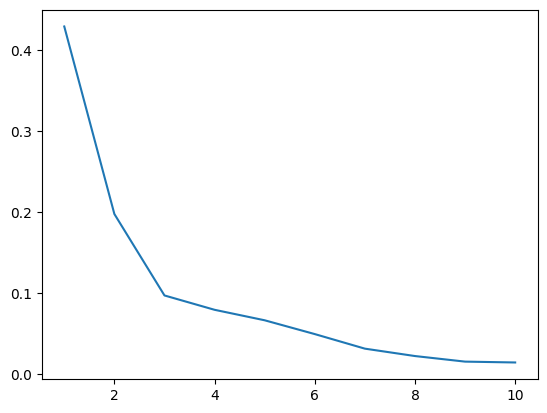

In [33]:
pca = PCA(n_components=10)
pca.fit(X)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

In [37]:
final_pca = PCA(n_components=3)
pc = final_pca.fit_transform(X)
pcaFeatures = {'PC1': pc[:, 0]
               ,'PC2': pc[:, 1]
                ,'PC3': pc[:, 2]}
X_pca = pd.DataFrame(data=pcaFeatures)

In [54]:
def plot_pca(df_pca, labels, silh=False):
    for label in np.unique(labels):
        idx = np.where(labels == label)[0]
        plt.scatter(df_pca.iloc[idx, 0], df_pca.iloc[idx, 1], label=label)
        
    if silh:
        silh_scores = np.round(silhouette_samples(df_pca, labels), 2)
        texts = []
        for i in range(len(labels)):
            texts.append(plt.annotate(silh_scores[i], (df_pca.iloc[i, 0], df_pca.iloc[i, 1]), fontsize=8))
        plt.text(2, -2.5, f'silhouette score:{np.round(np.mean(silh_scores), 3)}')      
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
        
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title('is_Vic')
    plt.legend()
    plt.show()

Разделение по классам в плоскости первых 2 ГК. Указан коэффициент силуэта для каждой точки и средний коэффициент, который, кстати, не слишком большой, учитывая, что это правильное разделение.

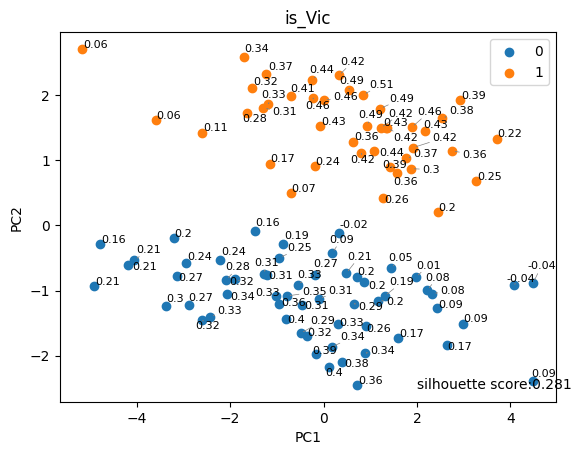

In [40]:
plot_pca(df_pca=X_pca, labels=scaled_df['is_Vic'], silh=True)

Model-based подход.

In [41]:
gm = GaussianMixture(n_components=2).fit(X_pca)
gm_clusters = gm.predict(X_pca)

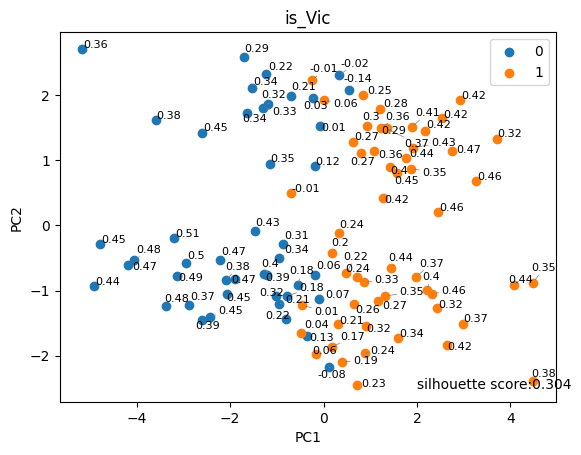

In [42]:
plot_pca(X_pca, gm_clusters, silh=True)

Сравним разные (по кол-ву кластеров и виду ковариационной матрицы) модели по BIC.

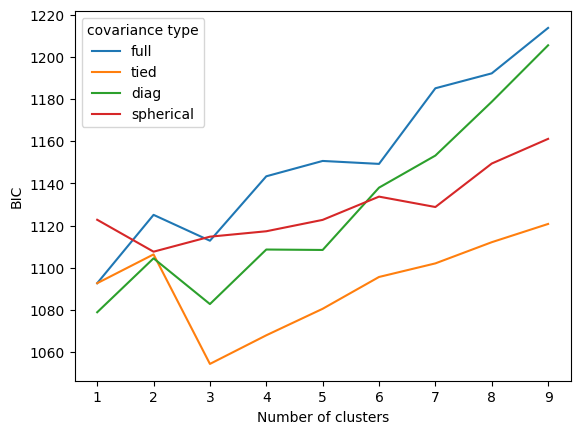

In [55]:
types = ["full", "tied", "diag", "spherical"]
clust_num = range(1, 10)
for cov_type in types:
    models = [GaussianMixture(n_components=n, covariance_type=cov_type, max_iter=1000, random_state=2).fit(X_pca) for n in clust_num] 
    plt.plot(clust_num, [m.bic(X_pca) for m in models], label=cov_type)
plt.xlabel("Number of clusters")
plt.ylabel("BIC")
plt.legend(title="covariance type")
plt.show()

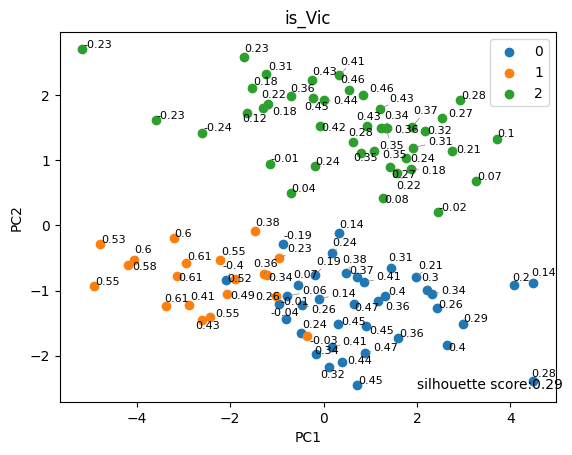

In [56]:
gm2 = GaussianMixture(n_components=3, covariance_type="tied", max_iter=1000, random_state=2).fit(X_pca)
gm_clusters2 = gm2.predict(X_pca)

plot_pca(X_pca, gm_clusters2, silh=True)

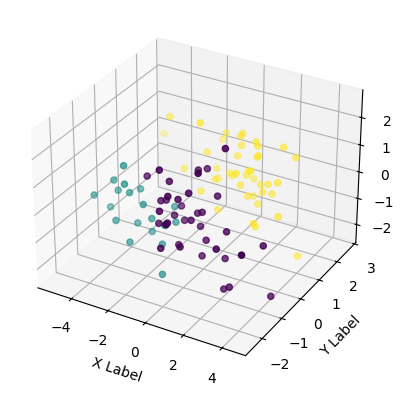

In [59]:
# %matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca.iloc[:, 0], X_pca.iloc[:, 1], X_pca.iloc[:, 2], c=gm_clusters2, cmap='viridis', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

DBSCAN. Подбор параметров по сетке.

In [60]:
eps = np.arange(0.1, 7, 0.1)
min_obs = np.arange(3, 50, 2)
params_list = [(x, y) for x in eps for y in min_obs]

In [61]:
score = -2
for params in params_list:
    curr_eps, curr_min_obs = params
    db = DBSCAN(eps=curr_eps, min_samples = curr_min_obs).fit(X_pca)
    y_pred = db.labels_
    if len(np.unique(y_pred)) < 3:
        continue
    curr_score = silhouette_score(X_pca, y_pred)
    if curr_score > score:
        score = curr_score
        best_params = params

In [62]:
best_params

(1.7000000000000002, 21)

Разделение верное, но некоторые точки помечены как выбросы.

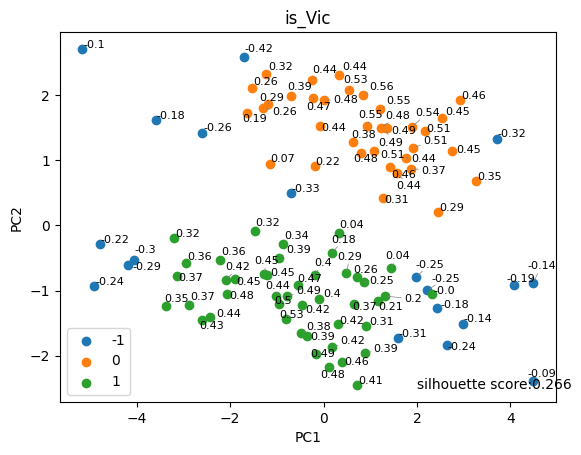

In [63]:
db = DBSCAN(eps=best_params[0], min_samples=best_params[1]).fit(X_pca)
db_labels = db.labels_
plot_pca(X_pca, db_labels, silh=True)

Bayesian Model-based. В качестве количества кластеров указываем их максимальное число, но в итоге их может оказаться меньше. (Количество кластеров в данном подходе не фиксировано и оценивается по данным).

In [64]:
def _n_parameters(self, X):
    """Return the number of free parameters in the model."""
    _, n_features = self.means_.shape
    # Number of effective components equals the number of unique labels
    n_effect_comp = len(np.unique(self.predict(X)))
    if self.covariance_type == 'full':
        cov_params = n_effect_comp * n_features * (n_features + 1) / 2.
    elif self.covariance_type == 'diag':
        cov_params = n_effect_comp * n_features
    elif self.covariance_type == 'tied':
        cov_params = n_features * (n_features + 1) / 2.
    elif self.covariance_type == 'spherical':
        cov_params = n_effect_comp
    mean_params = n_features * n_effect_comp
    return int(cov_params + mean_params + n_effect_comp - 1)

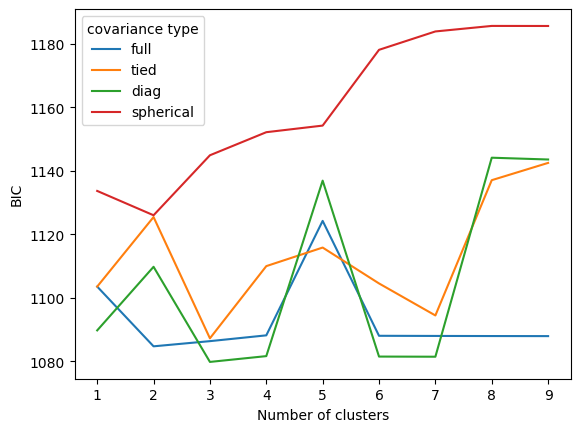

In [65]:
types = ["full", "tied", "diag", "spherical"]
clust_num = range(1, 10)
for cov_type in types:
    models = [BayesianGaussianMixture(n_components=n, covariance_type=cov_type, max_iter=1000, random_state=2).fit(X_pca) for n in clust_num]
    bic_list = [-2 * m.score(X_pca) * X_pca.shape[0] + _n_parameters(m, X_pca) * np.log(X_pca.shape[0]) for m in models]
    plt.plot(clust_num, bic_list, label=cov_type)
plt.xlabel("Number of clusters")
plt.ylabel("BIC")
plt.legend(title="covariance type")
plt.show() 

Модель правильно разделяет на 2 кластера, несмотря на указанное количество.

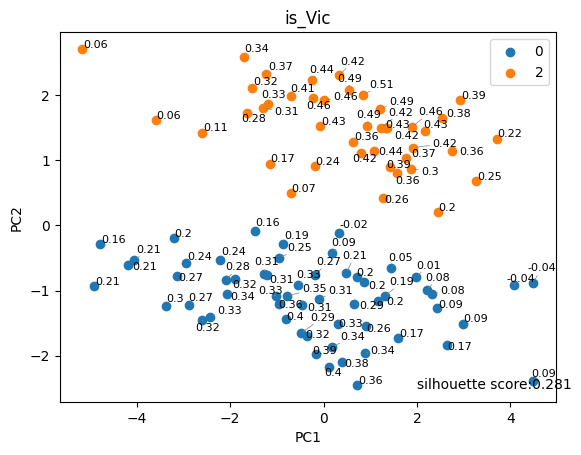

In [66]:
bgm =  BayesianGaussianMixture(n_components=3, covariance_type="diag", max_iter=1000, random_state=2).fit(X_pca)
bgm_clusters = bgm.predict(X_pca)
plot_pca(X_pca, bgm_clusters, silh=True)

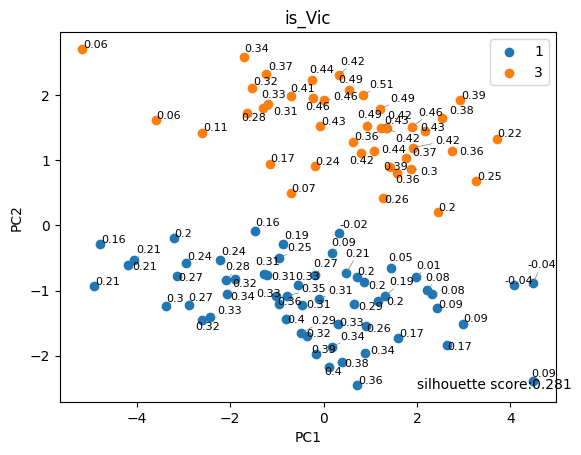

In [68]:
bgm2 =  BayesianGaussianMixture(n_components=6, covariance_type="diag", max_iter=1000, random_state=2).fit(X_pca)
bgm_clusters2 = bgm2.predict(X_pca)
plot_pca(X_pca, bgm_clusters2, silh=True)

Спектральная кластеризация. Подбор параметров по сетке (количество кластеров, способ задания графа, количество собственных векторов). 

In [71]:
n_clust_list = np.arange(2, 10, 1)
affinity_list = ['nearest_neighbors', 'rbf']
n_neigh = np.arange(3, 20, 2)
params_list_spectral = [(x, y, z) for x in n_clust_list for y in affinity_list for z in n_neigh]

In [72]:
len(params_list_spectral)

144

In [73]:
score = -2
for params in params_list_spectral:
    curr_clust_n, curr_affinity, curr_nn = params
    spec = SpectralClustering(n_clusters=curr_clust_n, random_state=2, affinity=curr_affinity, n_neighbors=curr_nn).fit(X_pca)
    y_pred = spec.labels_
    curr_score = silhouette_score(X_pca, y_pred)
    if curr_score > score:
        score = curr_score
        best_params_spec = params

In [74]:
best_params_spec

(5, 'nearest_neighbors', 7)

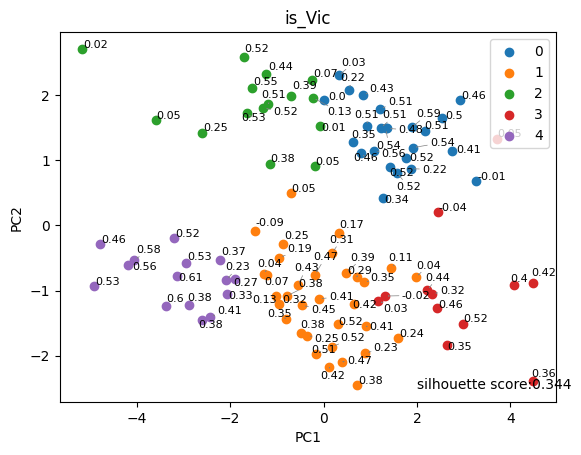

In [75]:
spectral = SpectralClustering(n_clusters=best_params_spec[0], random_state=2,
                              affinity=best_params_spec[1], n_neighbors=best_params_spec[2]).fit(X_pca)
plot_pca(X_pca, spectral.labels_, silh=True)

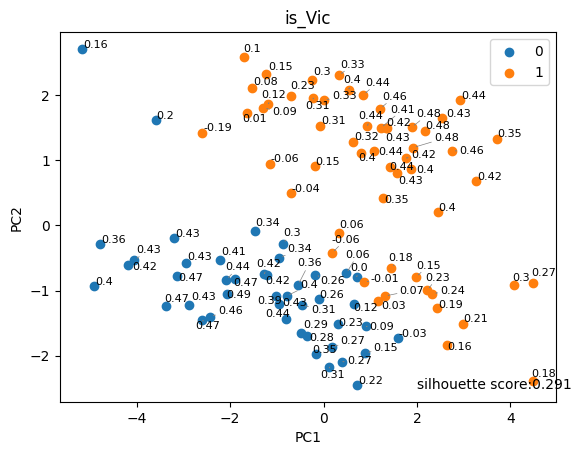

In [76]:
spectral2 = SpectralClustering(n_clusters=2, random_state=2,
                              affinity=best_params_spec[1], n_neighbors=best_params_spec[2]).fit(X_pca)
plot_pca(X_pca, spectral2.labels_, silh=True)

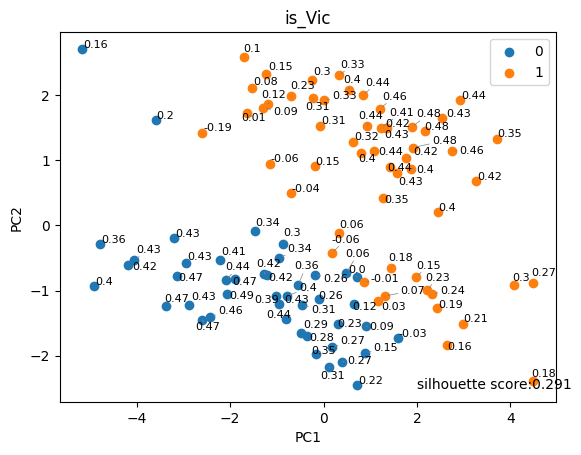

In [77]:
spectral3 = SpectralClustering(n_clusters=2, random_state=2,
                              affinity='rbf', n_neighbors=best_params_spec[2]).fit(X_pca)
plot_pca(X_pca, spectral2.labels_, silh=True)

LSA.

In [78]:
text_df = pd.read_csv('polarity-dataset.csv')
text_df.head()

,sentence,label
0,"simplistic , silly and tedious .",-1
1,"it's so laddish and juvenile , only teenage bo...",-1
2,exploitative and largely devoid of the depth o...,-1
3,[garbus] discards the potential for pathologic...,-1
4,a visually flashy but narratively opaque and e...,-1


In [79]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
#     print(texts)  
    return texts

In [80]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
#     print(dictionary)
#     print(doc_term_matrix)
    return dictionary, doc_term_matrix

In [83]:
def create_gensim_lsa_model(doc_clean, number_of_topics, words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [ ]:
# Задаем число тем
number_of_topics = 2

# Задаем число слов в каждой теме
words = 10

document_list = text_df['sentence'].to_list()
titles =  text_df['label'].to_list()


clean_text = preprocess_data(document_list)
doc_term_matr = prepare_corpus(clean_text)[1]

model = create_gensim_lsa_model(clean_text, number_of_topics, words)

In [85]:
len(doc_term_matr)

10662

In [87]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for number_of_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        print(model)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [88]:
def plot_graph(doc_clean, start, stop, step):
    dictionary, doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [ ]:
start,stop,step=2,9,1
plot_graph(clean_text,start,stop,step)